In [1]:
%cd ../..

C:\Users\ManuJoseph\OneDrive - Thoucentric\Work\Projects\Playground\AdvancedTimeSeriesForecastingBook\Github\Modern-Time-Series-Forecasting-with-Python-


In [2]:
import os
import shutil

import joblib
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"

from pathlib import Path

from src.forecasting.ml_forecasting import (
    MissingValueConfig,
    calculate_metrics,
)
from src.utils import plotting_utils
from tqdm.autonotebook import tqdm
from src.forecasting.ml_forecasting import calculate_metrics
from src.utils import ts_utils
from IPython.display import display, HTML
# %load_ext autoreload
# %autoreload 2
np.random.seed(42)
tqdm.pandas()

C:\Users\ManuJoseph\OneDrive - Thoucentric\Work\Projects\Playground\AdvancedTimeSeriesForecastingBook\Github\Modern-Time-Series-Forecasting-with-Python-\src\utils\data_utils.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
os.makedirs("imgs/chapter_15", exist_ok=True)
os.makedirs("notebooks/Chapter15/saved_weights", exist_ok=True)
preprocessed = Path("data/london_smart_meters/preprocessed")
output = Path("data/london_smart_meters/output")
# Make True to select a subsample. Helps with faster training.
TRAIN_SUBSAMPLE = True

## Utility Functions

In [4]:
def format_plot(fig, legends=None, xlabel="Time", ylabel="Value", title="", font_size=15):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t: t.update(name=next(names)))
    fig.update_layout(
        autosize=False,
        width=900,
        height=500,
        title_text=title,
        title={"x": 0.5, "xanchor": "center", "yanchor": "top"},
        titlefont={"size": 20},
        legend_title=None,
        legend=dict(
            font=dict(size=font_size),
            orientation="h",
            yanchor="bottom",
            y=0.98,
            xanchor="right",
            x=1,
        ),
        yaxis=dict(
            title_text=ylabel,
            titlefont=dict(size=font_size),
            tickfont=dict(size=font_size),
        ),
        xaxis=dict(
            title_text=xlabel,
            titlefont=dict(size=font_size),
            tickfont=dict(size=font_size),
        )
    )
    return fig

In [5]:
from itertools import cycle


def plot_forecast(pred_df, forecast_columns, forecast_display_names=None):
    if forecast_display_names is None:
        forecast_display_names = forecast_columns
    else:
        assert len(forecast_columns) == len(forecast_display_names)
    mask = ~pred_df[forecast_columns[0]].isnull()
    colors = [
        "rgba(" + ",".join([str(c) for c in plotting_utils.hex_to_rgb(c)]) + ",<alpha>)"
        for c in px.colors.qualitative.Plotly
    ]
    act_color = colors[0]
    colors = cycle(colors[1:])
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=pred_df[mask].index,
            y=pred_df[mask].energy_consumption,
            mode="lines",
            line=dict(color=act_color.replace("<alpha>", "0.9")),
            name="Actual Consumption",
        )
    )
    for col, display_col in zip(forecast_columns, forecast_display_names):
        fig.add_trace(
            go.Scatter(
                x=pred_df[mask].index,
                y=pred_df.loc[mask, col],
                mode="lines",
                line=dict(dash="dot", color=next(colors).replace("<alpha>", "1")),
                name=display_col,
            )
        )
    return fig

def highlight_abs_min(s, props=''):
    return np.where(s.abs() == np.nanmin(np.abs(s.values)), props, '')

def evaluate_forecast(pred_df, train_data, fc_column, name, target_name="energy_consumption"):
    metric_l = []
    for _id in tqdm(pred_df.index.get_level_values(0).unique(), desc="Calculating metrics..."):
        target = pred_df.xs(_id)[[target_name]]
        _y_pred = pred_df.xs(_id)[[fc_column]]
        history = train_data.xs(_id)[[target_name]]
        # display(history.tail())
        # display(_y_pred.head())
        # display(target.head())
        metric_l.append(
            calculate_metrics(target, _y_pred, name=name, y_train=history)
        )
    eval_metrics_df = pd.DataFrame(metric_l)
    agg_metrics = {
            "Algorithm": name,
            "MAE": np.nanmean(np.abs(pred_df[fc_column]-pred_df[target_name])),
            "MSE": np.nanmean(np.power(pred_df[fc_column]-pred_df[target_name], 2)),
            "meanMASE": eval_metrics_df.loc[:, "MASE"].mean(),
            "Forecast Bias": 100*(np.nansum(pred_df[fc_column])-np.nansum(pred_df[target_name]))/np.nansum(pred_df[target_name])
    }
    return agg_metrics, eval_metrics_df

from pytorch_lightning.utilities.cloud_io import load as pl_load

def load_weights(model, weight_path):
    state_dict = pl_load(weight_path)
    model.load_state_dict(state_dict)

In [6]:
def create_one_day_ahead_fc(x):
    x[f'{tag}_one_day'] = 0
    for i in range(0, len(x)-48,48):
        # print(i)
        x.iloc[i:i+48,-1] = x[[col for col in x.columns if col.startswith(f"{tag}_step")]].iloc[i].values
    return x
    

In [7]:
from collections import namedtuple

FeatureConfig = namedtuple(
    "FeatureConfig",
    [
        "target",
        "index_cols",
        "static_categoricals",
        "static_reals",
        "time_varying_known_categoricals",
        "time_varying_known_reals",
        "time_varying_unknown_reals",
        "group_ids"
    ],
)

## Reading the data

In [8]:
try:
    #Reading the missing value imputed and train test split data
    train_df = pd.read_parquet(preprocessed/"selected_blocks_train_missing_imputed_feature_engg.parquet")
    # Read in the Validation dataset as test_df so that we predict on it
    test_df = pd.read_parquet(preprocessed/"selected_blocks_val_missing_imputed_feature_engg.parquet")
    # test_df = pd.read_parquet(preprocessed/"selected_blocks_test_missing_imputed_feature_engg.parquet")
except FileNotFoundError:
    display(HTML("""
    <div class="alert alert-block alert-warning">
    <b>Warning!</b> File not found. Please make sure you have run 01-Feature Engineering.ipynb in Chapter06
    </div>
    """))

In [9]:
# To run on smaller set of data for daster iteration.
if TRAIN_SUBSAMPLE:
    print("sub sampling")
    SAMPLE = 10
    sampled_LCLids = pd.Series(train_df.LCLid.unique().remove_unused_categories().categories).sample(SAMPLE, random_state=99).tolist()
    train_df = train_df.loc[train_df.LCLid.isin(sampled_LCLids)]
    test_df = test_df.loc[test_df.LCLid.isin(sampled_LCLids)]

sub sampling


## Defining the different features

In [10]:
feat_config = FeatureConfig(
    target="energy_consumption",
    index_cols=["LCLid", "timestamp"],
    static_categoricals=[
        "LCLid",
        "stdorToU",
        "Acorn",
        "Acorn_grouped",
        "file",
    ],  # Categoricals which does not change with time
    static_reals=[],  # Reals which does not change with time
    time_varying_known_categoricals=[  # Categoricals which change with time
        "holidays",
        "timestamp_Dayofweek",
    ],
    time_varying_known_reals=[  # Reals which change with time
        "apparentTemperature",
    ],  
    time_varying_unknown_reals=[  # Reals which change with time, but we don't have the future. Like the target
        "energy_consumption"
    ],  
    group_ids=[  # Feature or list of features which uniquely identifies each entity
        "LCLid"
    ],  
)

### Creating a continuous time index for PyTorch Forecasting

In [11]:
# Combining train and test with a flag
train_df['train'] = True
test_df['train'] = False
data = pd.concat([train_df, test_df])
del train_df, test_df
# Adding the time index
data['time_idx'] = data.timestamp.apply(lambda x: x.value)
diff = data.iloc[1]['time_idx'] - data.iloc[0]['time_idx']
data["_min_time_idx"] = data.groupby("LCLid", observed=True)['time_idx'].transform("min")
data['time_idx'] = ((data['time_idx']-data['_min_time_idx'])/diff).astype(int)
data.drop(columns="_min_time_idx", inplace=True)
# separating to train and test
train_df = data.loc[data.train]
test_df = data.loc[~data.train]
del data

### Converting the categoricals to `object` dtype

In [12]:
train_df[
    feat_config.static_categoricals + feat_config.time_varying_known_categoricals
] = train_df[
    feat_config.static_categoricals + feat_config.time_varying_known_categoricals
].astype(
    "object"
)

test_df[
    feat_config.static_categoricals + feat_config.time_varying_known_categoricals
] = test_df[
    feat_config.static_categoricals + feat_config.time_varying_known_categoricals
].astype(
    "object"
)

### Handling Missing Values

In [13]:
#Checking missing values
n = train_df.isna().any()
n[n]

pressure                                          True
energy_consumption_lag_1                          True
energy_consumption_lag_2                          True
energy_consumption_lag_3                          True
energy_consumption_lag_4                          True
energy_consumption_lag_5                          True
energy_consumption_lag_46                         True
energy_consumption_lag_47                         True
energy_consumption_lag_48                         True
energy_consumption_lag_49                         True
energy_consumption_lag_50                         True
energy_consumption_lag_334                        True
energy_consumption_lag_335                        True
energy_consumption_lag_336                        True
energy_consumption_lag_337                        True
energy_consumption_lag_338                        True
energy_consumption_rolling_3_mean                 True
energy_consumption_rolling_3_std                  True
energy_con

In [14]:
# We aren't using any of these features. So let it be

# Training Temporal Fusion Transformer

In [15]:
import pytorch_lightning as pl
pl.seed_everything(42)
import torch

from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import RMSE, MAE

Global seed set to 42


In [16]:
# # Load the TensorBoard notebook extension
# %load_ext tensorboard
# os.makedirs("lightning_logs", exist_ok=True)
# %tensorboard --logdir lightning_logs/

# Or start the tensorboard in a separate command prompt/terminal using
# tensorboard --logdir lightning_logs/

### Config

In [17]:
max_prediction_length = 48
max_encoder_length = 48*2
batch_size = 512  # set this to a value which your GPU can handle
train_model = True # Set this to True to train model. Else will load saved models ! Warning! Training on full dataset takes 3-6 hours

In [18]:
tag = "TFT"

In [19]:
metric_record = []
individual_metrics = dict()

### Creating dataframes for train, val and test

In [20]:
train_df.timestamp.max(), test_df.timestamp.min()

(Timestamp('2013-12-31 23:30:00'), Timestamp('2014-01-01 00:00:00'))

In [21]:
#Adding 2 days of history (48*2) to create the samples
history_cutoff = train_df.timestamp.max() - pd.Timedelta(2, "D")
hist_df = train_df[train_df.timestamp>history_cutoff]
print(f"History Min: {hist_df.timestamp.min()} | Max: {hist_df.timestamp.max()} | Length: {len(hist_df.timestamp.unique())}")

History Min: 2013-12-30 00:00:00 | Max: 2013-12-31 23:30:00 | Length: 96


In [22]:
#Keeping 1 days aside as a validation set
cutoff = train_df.timestamp.max() - pd.Timedelta(1, "D")
#Adding 2 days of history (48*2) to create the samples
history_cutoff = train_df.timestamp.max() - pd.Timedelta(3, "D")
val_history = train_df[(train_df.timestamp>=history_cutoff)&(train_df.timestamp<=cutoff)].reset_index(drop=True)
val_df = train_df[train_df.timestamp>cutoff].reset_index(drop=True)
train_df = train_df[train_df.timestamp<=cutoff].reset_index(drop=True)
print("Split Timestamps:")
print(f"Train Max: {train_df.timestamp.max()} | Val History Min and Max: {val_history.timestamp.min(), val_history.timestamp.max()} | Val Min and Max: {val_df.timestamp.min(), val_df.timestamp.max()}")
print(f"Val History Size: {len(val_history.timestamp.unique())} | Val Size: {len(val_df.timestamp.unique())}")

Split Timestamps:
Train Max: 2013-12-30 23:30:00 | Val History Min and Max: (Timestamp('2013-12-28 23:30:00'), Timestamp('2013-12-30 23:30:00')) | Val Min and Max: (Timestamp('2013-12-31 00:00:00'), Timestamp('2013-12-31 23:30:00'))
Val History Size: 97 | Val Size: 48


In [23]:
pred_df = test_df[feat_config.index_cols+[feat_config.target]+['time_idx']].copy()
# pred_df.set_index(feat_config.index_cols, inplace=True)

In [24]:
cols = feat_config.index_cols + [feat_config.target]
full_df = pd.concat(
    [
        train_df[cols],
        val_df[cols],
    ]
).set_index(feat_config.index_cols)

### Converting data into TimeSeriesDataset from PyTorch Forecasting

In [25]:
# Defining the training dataset
training = TimeSeriesDataSet(
    train_df,
    time_idx="time_idx",
    target=feat_config.target,
    group_ids=feat_config.group_ids,
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=feat_config.static_categoricals,
    static_reals=feat_config.static_reals,
    time_varying_known_categoricals=feat_config.time_varying_known_categoricals,
    time_varying_known_reals=feat_config.time_varying_known_reals,
    time_varying_unknown_reals=[
        "energy_consumption",
    ],
    target_normalizer=GroupNormalizer(
        groups=feat_config.group_ids, transformation=None
    )
)
# Defining the validation dataset with the same parameters as training
validation = TimeSeriesDataSet.from_dataset(training, pd.concat([val_history,val_df]).reset_index(drop=True), stop_randomization=True)
# Defining the test dataset with the same parameters as training
test = TimeSeriesDataSet.from_dataset(training, pd.concat([hist_df, test_df]).reset_index(drop=True), stop_randomization=True)

In [26]:
# Making the dataloaders
# num_workers can be increased in linux to speed-up training
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [27]:
# Testing the dataloader
x, y = next(iter(train_dataloader))
print("\nsizes of x =")
for key, value in x.items():
    print(f"\t{key} = {value.size()}")
print("\nsize of y =")
print(f"\ty = {y[0].size()}")


sizes of x =
	encoder_cat = torch.Size([512, 96, 7])
	encoder_cont = torch.Size([512, 96, 2])
	encoder_target = torch.Size([512, 96])
	encoder_lengths = torch.Size([512])
	decoder_cat = torch.Size([512, 48, 7])
	decoder_cont = torch.Size([512, 48, 2])
	decoder_target = torch.Size([512, 48])
	decoder_lengths = torch.Size([512])
	decoder_time_idx = torch.Size([512, 48])
	groups = torch.Size([512, 1])
	target_scale = torch.Size([512, 2])

size of y =
	y = torch.Size([512, 48])


### Initializing the Model

In [28]:
from pytorch_forecasting.models import TemporalFusionTransformer

In [29]:
cardinality = [len(training.categorical_encoders[c].classes_) for c in training.categoricals]
embedding_sizes = {
    col: (x, min(50, (x + 1) // 2))
    for col, x in zip(training.categoricals, cardinality)
}

In [32]:
model_params = {
    "hidden_size": 128,
    "lstm_layers": 2,
    "attention_head_size": 4,
    "hidden_continuous_size": 128,
    "embedding_sizes": embedding_sizes
}
other_params = dict(
    learning_rate=1e-4,
    optimizer="adam",
    loss=RMSE(),
    logging_metrics=[RMSE(), MAE()],
)

In [33]:
model = TemporalFusionTransformer.from_dataset(
    training,**{**model_params, **other_params})
#Testing out the model
x, y = next(iter(train_dataloader))
_ = model(x)
type(_), _.prediction.shape

(pytorch_forecasting.utils.TupleOutputMixIn.to_network_output.<locals>.Output,
 torch.Size([512, 48, 1]))

### Training the model

In [34]:
saved_model_sampled = f'notebooks/Chapter15/saved_weights/{tag}_sampled.wt'
saved_model_full = f'notebooks/Chapter15/saved_weights/{tag}.wt'

In [35]:
if train_model:
    trainer = pl.Trainer(
        auto_select_gpus=True,
        gpus=-1,
        min_epochs=1,
        max_epochs=20,
        callbacks=[
            pl.callbacks.EarlyStopping(monitor="val_loss", patience=3 if TRAIN_SUBSAMPLE else 4*3),
            pl.callbacks.ModelCheckpoint(
                monitor="val_loss", save_last=True, mode="min", auto_insert_metric_name=True
            ),
        ],
        val_check_interval=1.0 if TRAIN_SUBSAMPLE else 2000,
        log_every_n_steps=50 if TRAIN_SUBSAMPLE else 2000,
    )
    trainer.fit(
        model,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )
    #Loading the best model
    best_model_path = trainer.checkpoint_callback.best_model_path
    best_model = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
    print(f"Loading the best model from: {best_model_path}")
    shutil.copy(best_model_path, saved_model_sampled if TRAIN_SUBSAMPLE else saved_model_full)
else:
    best_model_path = saved_model_sampled if TRAIN_SUBSAMPLE else saved_model_full
    load_weights(model, best_model_path)
    best_model =  model
    print ("Skipping Training and loading the model from {best_model_path}")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 223   
3  | prescalers                         | ModuleDict                      | 512   
4  | static_variable_selection          | VariableSelectionNetwork        | 2.1 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 135 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 68.2 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 66.3 K
8  | static_

Validation sanity check: 0it [00:00, ?it/s]

C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 42
C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

NameError: name 'AutoformerModel' is not defined

In [37]:
pred, index = best_model.predict(test, return_index=True, show_progress_bar=True)
index[[f"{tag}_step_{i}" for i in range(pred.shape[-1])]] = pred
pred_df = (
    pred_df.reset_index()
    .merge(
        index[["time_idx", "LCLid", f"{tag}_step_0"]],
        on=["time_idx", "LCLid"],
        how="left",
    )
    .dropna(subset=["LCLid", f"{tag}_step_0"]) # Last 48 timesteps do not have a one step FC because single multi-step FC covered it
    .set_index(feat_config.index_cols)
)
# Evaluating the forecast
agg_metrics, eval_metrics_df = evaluate_forecast(
    pred_df = pred_df,
    train_data = full_df,
    fc_column=f"{tag}_step_0",
    name=f"{tag}_step_0",
)
metric_record.append(agg_metrics)
individual_metrics[f"{tag}_step_0"]=eval_metrics_df

Predict:   0%|          | 0/226 [00:00<?, ? batches/s]

Calculating metrics...:   0%|          | 0/10 [00:00<?, ?it/s]

In [38]:
# pred_df = pred_df.drop(columns=["N-BEATS(I)_single_step", "N-BEATS(I)_one_day_x"]).rename(columns={"N-BEATS(I)_one_day_y": "N-BEATS(I)_one_day"})

In [39]:
index = index.groupby("LCLid").apply(create_one_day_ahead_fc)
pred_df = (
    pred_df.reset_index()
    .merge(
        index[["time_idx", "LCLid", f"{tag}_one_day"]],
        on=["time_idx", "LCLid"],
        how="left",
    )
    .set_index(feat_config.index_cols)
)
# Evaluating the forecast
agg_metrics, eval_metrics_df = evaluate_forecast(
    pred_df=pred_df,
    train_data=full_df,
    fc_column=f"{tag}_one_day",
    name=f"{tag}_one_day",
)
metric_record.append(agg_metrics)
individual_metrics[f"{tag}_one_day"] = eval_metrics_df

Calculating metrics...:   0%|          | 0/10 [00:00<?, ?it/s]

In [40]:
pd.DataFrame(metric_record)

,Algorithm,MAE,MSE,meanMASE,Forecast Bias
0,TFT_step_0,0.102906,0.031822,1.182472,-0.804368
1,TFT_one_day,0.125430,0.040559,1.416142,6.164836


### Interpretability

In [61]:
import matplotlib.pyplot as plt
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

# idx = 0

#### Global Interpretability

In [44]:
raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)
interpretation = best_model.interpret_output(raw_predictions, reduction="sum")

In [124]:
def plot_attention(attention, ax):
    attention = attention / attention.sum(-1).unsqueeze(-1)
    ax.plot(
        np.arange(-best_model.hparams.max_encoder_length, attention.size(0) - best_model.hparams.max_encoder_length), attention
    )
    ax.set_xlabel("Time index", fontsize=MEDIUM_SIZE)
    ax.set_ylabel("Attention", fontsize=MEDIUM_SIZE)
    ax.set_title("Attention", fontsize=BIGGER_SIZE)
    ax.tick_params(axis='y', labelsize= SMALL_SIZE)
    ax.tick_params(axis='x', labelsize= SMALL_SIZE)

In [89]:
# variable selection
def make_selection_plot(title, values, labels, ax):
    order = np.argsort(values)
    values = values / values.sum(-1).unsqueeze(-1)
    ax.barh(np.arange(len(values)), values[order] * 100, tick_label=np.asarray(labels)[order])
    ax.set_title(title, fontsize=BIGGER_SIZE)
    ax.set_xlabel("Importance in %", fontsize=MEDIUM_SIZE)
    ax.tick_params(axis='y', labelsize= SMALL_SIZE)
    ax.tick_params(axis='x', labelsize= SMALL_SIZE)
    # plt.tight_layout()
    # return fig

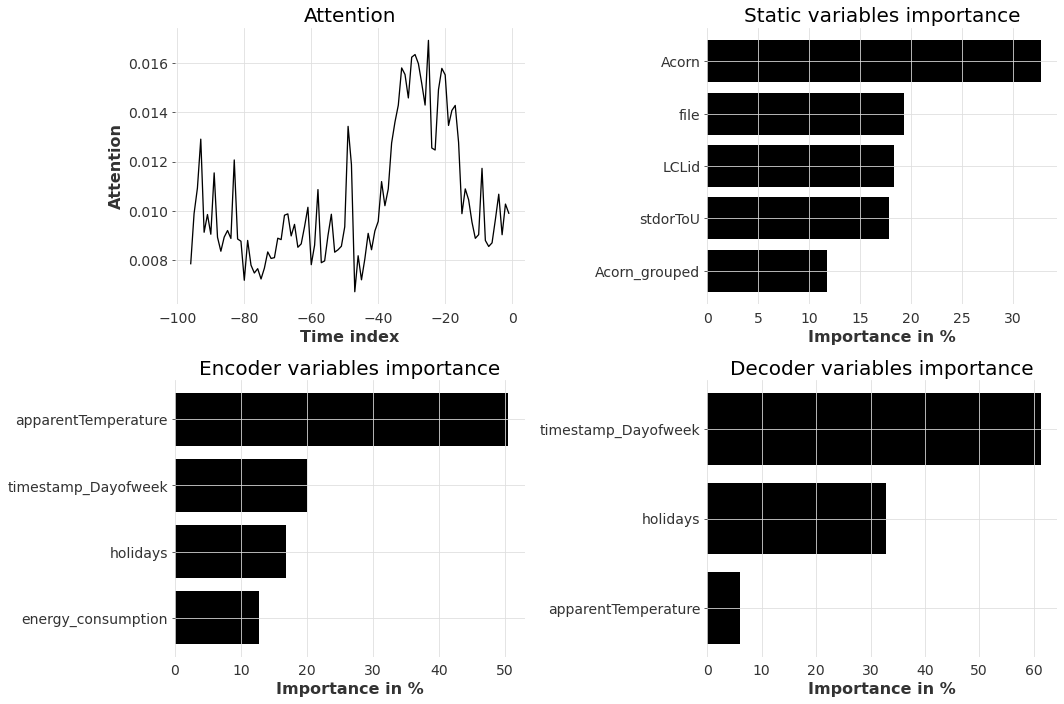

In [125]:
#One line plot
# best_model.plot_interpretation(interpretation)
# Plotting own for more flexibility
fig, axes = plt.subplots(2,2, figsize=(15,10))
plot_attention(interpretation["attention"].detach().cpu(), axes[0][0])
make_selection_plot(
            "Static variables importance", interpretation["static_variables"].detach().cpu(), best_model.static_variables, axes[0][1]
        )
make_selection_plot(
            "Encoder variables importance", interpretation["encoder_variables"].detach().cpu(), best_model.encoder_variables, axes[1][0]
        )
make_selection_plot(
            "Decoder variables importance", interpretation["decoder_variables"].detach().cpu(), best_model.decoder_variables, axes[1][1]
        )

plt.tight_layout(pad=1.5)
fig.savefig("imgs/chapter_15/tft_interp.png")

#### Local Interpretability

In [123]:
interpretation_granular = best_model.interpret_output(raw_predictions, reduction="none")

inv_transform_group = lambda x : training.categorical_encoders["__group_id__LCLid"].inverse_transform(x)

idx = 0

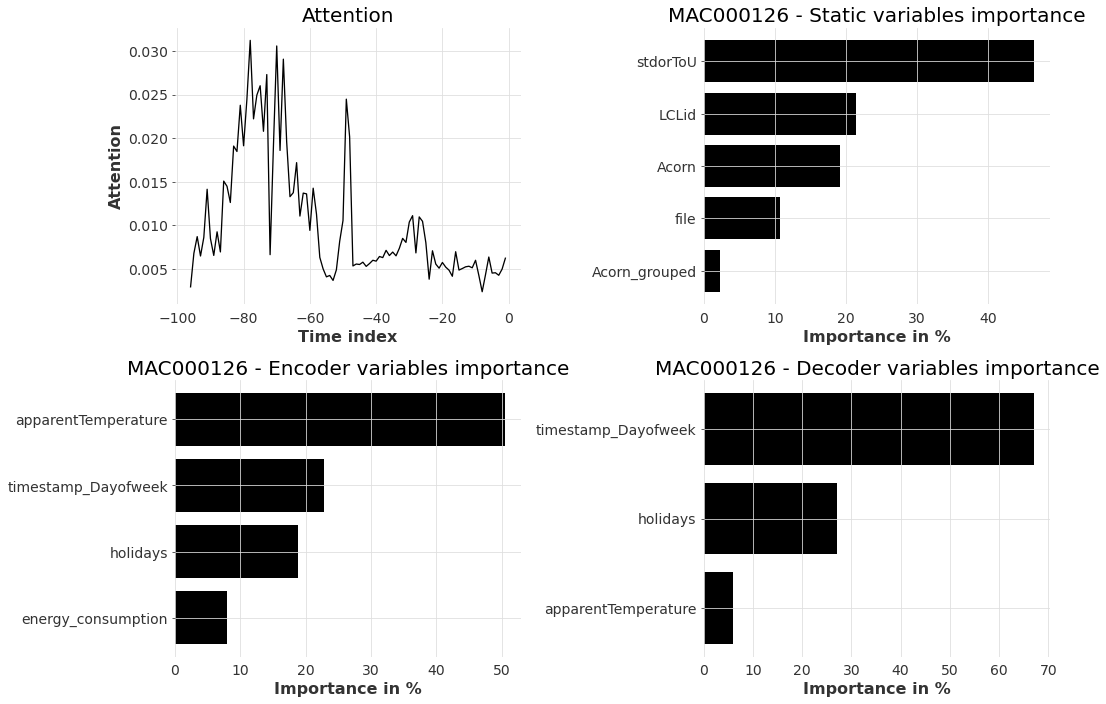

In [130]:
fig, axes = plt.subplots(2,2, figsize=(15,10))
mac = inv_transform_group(x["groups"][idx])
plot_attention(interpretation_granular["attention"][idx].detach().cpu(), axes[0][0])
make_selection_plot(
            f"{mac} - Static variables importance", interpretation_granular["static_variables"][idx].detach().cpu(), best_model.static_variables, axes[0][1]
        )
make_selection_plot(
            f"{mac} - Encoder variables importance", interpretation_granular["encoder_variables"][idx].detach().cpu(), best_model.encoder_variables, axes[1][0]
        )
make_selection_plot(
            f"{mac} - Decoder variables importance", interpretation_granular["decoder_variables"][idx].detach().cpu(), best_model.decoder_variables, axes[1][1]
        )

plt.tight_layout(pad=1.5)
fig.savefig("imgs/chapter_15/tft_interp_indiv.png")

#### Bonus: Partial Dependency

In [136]:
train_df.apparentTemperature.describe()

count    297744.000000
mean         10.053911
std           7.315151
min          -8.880000
25%           4.370000
50%          10.970000
75%          15.530000
max          32.419998
Name: apparentTemperature, dtype: float64

In [141]:
dependency = best_model.predict_dependency(
    val_dataloader.dataset, "apparentTemperature", np.linspace(-8, 32, 48), show_progress_bar=True, mode="dataframe"
)

Predict:   0%|          | 0/48 [00:00<?, ? batches/s]

C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature nam

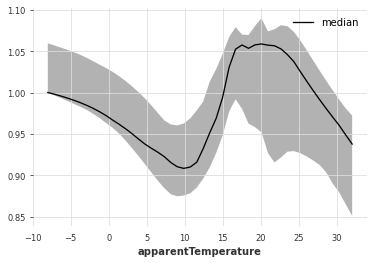

In [142]:
# plotting median and 25% and 75% percentile
agg_dependency = dependency.groupby("apparentTemperature").normalized_prediction.agg(
    median="median", q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75)
)
ax = agg_dependency.plot(y="median")
ax.fill_between(agg_dependency.index, agg_dependency.q25, agg_dependency.q75, alpha=0.3);